In [52]:
# Uncomment the setting to be evaluated, and comment all others.
# These names correspond to the names of the saved estimators (in the
# estimators folder), and also to the names of the python scripts used
# to train those estimators.

# setting = "Linear_n100_s1_wdim10"
# setting = "Linear_n100_s5_wdim10"
# setting = "Linear_n500_s1_wdim10"
# setting = "Linear_n500_s5_wdim10"
setting = "Gam_m10_n100_s1_wdim10"
# setting = "Gam_m10_n100_s5_wdim10"
# setting = "Gam_m10_n500_s1_wdim10"
# setting = "Gam_m10_n500_s5_wdim10"
# setting = "Gam_m10_n100_s1_wdim10_ablation1"

In [53]:
# import relevant libraries

import numpy as np
import pandas as pd
from plotnine import *
import torch
from torch import nn, optim
from torch.distributions import normal, uniform, multivariate_normal, bernoulli, multinomial, chi2, exponential
from torch.autograd import Variable
from torch.nn import functional as F
import copy
import os # to check if file exists
from shutil import copyfile # to copy backup file

import learn2predict as l2p

In [54]:
# Use the device defined in learn2predict (should be the GPU with the most free memory)
device = l2p.device

In [55]:
if setting=="Linear_n100_s1_wdim10":
    gam = False
    M = None
    n = 100
    s = 1
    wdim = 10
    ablation = 0
elif setting=="Linear_n100_s5_wdim10":
    gam = False
    M = None
    n = 100
    s = 5
    wdim = 10
    ablation = 0
elif setting=="Linear_n500_s1_wdim10":
    gam = False
    M = None
    n = 500
    s = 1
    wdim = 10
    ablation = 0
elif setting=="Linear_n500_s5_wdim10":
    gam = False
    M = None
    n = 500
    s = 5
    wdim = 10
    ablation = 0
elif setting=="Gam_m10_n100_s1_wdim10":
    gam = True
    M = 10
    n = 100
    s = 1
    wdim = 10
    ablation = 0
elif setting=="Gam_m10_n100_s5_wdim10":
    gam = True
    M = 10
    n = 100
    s = 5
    wdim = 10
    ablation = 0
elif setting=="Gam_m10_n500_s1_wdim10":
    gam = True
    M = 10
    n = 500
    s = 1
    wdim = 10
    ablation = 0
elif setting=="Gam_m10_n500_s5_wdim10":
    gam = True
    M = 10
    n = 500
    s = 5
    wdim = 10
    ablation = 0
elif setting=="Gam_m10_n100_s1_wdim10_ablation1":
    gam = True
    M = 10
    n = 100
    s = 1
    wdim = 10
    ablation = 1
else:
    raise Exception("Invalid setting.")

In [56]:
# Load the trained estimator

if gam:
    Pi, Pi_opt, Pi_sched = l2p.initPi(s,s+2,wdim,M=M,gam=gam)
    rank_based = True
else:
    Pi, Pi_opt, Pi_sched = l2p.initPi(s,s+2,wdim,gam=gam)
    rank_based = False

# initialize the procedure
T, T_opt, T_sched = l2p.initT(rank_based=rank_based,gam=gam,ablation=ablation)

fn_main = './estimators/'+(('Gam' + '_m' + str(M)) if gam else ('Linear')) + '_n' + str(n) + '_s' + str(s) + '_wdim' + str(wdim)
if ablation!=0:
    fn_main = fn_main + '_ablation' + str(ablation)
iteration, loss_list = l2p.load_model(T, T_opt, T_sched, Pi, Pi_opt, Pi_sched, fn_main+'.tar', fl_backup = fn_main+'_backup.tar')

print("Iteration:",iteration)

Iteration: 1000001


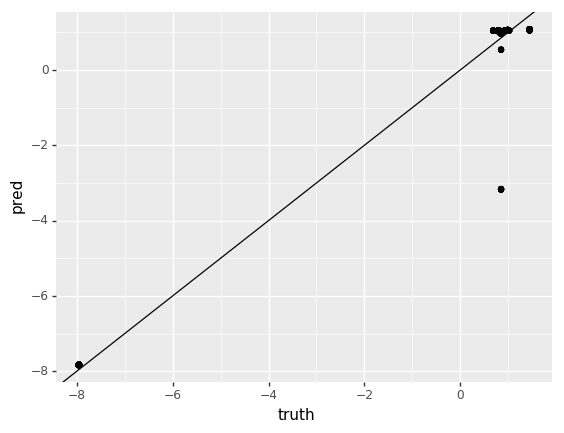

<ggplot: (8752506524936)>


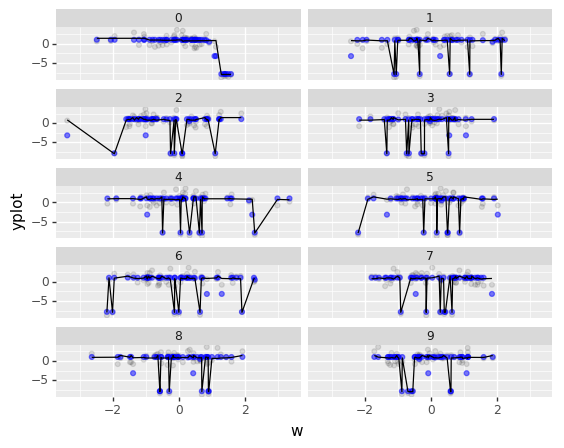

<ggplot: (-9223363284408154017)>
Average MSEs across runs. Column 1 gives results for unsymmetrized AMC, column 2 for symmetrized AMC, column 3 for OLS regression, and column 4 for lasso regression.
[1.071 0.958 4.769 4.538]


In [57]:
# Compute MSE performance against OLS and lasso.
# Do a total of reps Monte Carlo replication, and plot the fits from
# the first run. One of the plots will display predicted vs true regression
# function values, and the other will display predictions and truth on y-axis,
# and w values on the x-axis (one facet for each coordinate).
# Note: This is not the code that was used to evaluate the performance of the estimators.
#       This is just to provide an interactive way to get an overall sense of their performance.
#       Importantly, the simulation setting for evaluating the generalized additive model here
#       is not the same as the settings in Petersen (since those are generated using an R function,
#       and we want this Jupyter notebook to be self-contained). We also do not compare to the FLAM
#       estimator in this notebook (because, again, this estimator is implemented in R).
#       See the file eval_flam.R for code to evaluate the performance of the FLAM estimator and to
#       generate data based on Scenarios 1-4 from Petersen et al.

# Number of Monte Carlo replicates
reps = 25

# Which sparsity level should be used in this simulation?
sim_s = s
# Should data be simulated for the gam setting or for the linear setting?
sim_gam = gam
max_radius = 5
num_plot = 1

from random import sample 
from sklearn.linear_model import LinearRegression, LassoCV

# Error distribution
E = normal.Normal(loc = torch.zeros(1), scale = torch.ones(1))
# Covariate distribution
# Isotropic Gaussian in this performance evaluation
# Note that the covariance matrix was sampled from a Wishart in the experiments
# evaluating the performance of our learned linear estimator (to evaluate performance
# at distributions with correlated covariates)
W = normal.Normal(loc = torch.zeros(wdim), scale = torch.ones(wdim))
# Exponential distribution
expo = exponential.Exponential(1.0)

mses = np.zeros((reps,4)) # Pre-allocate matrix

for i_rep in range(reps):

    # load model at last save point
    n_sim_train = n
    n_sim_test = 50
    n_sim = n_sim_train + n_sim_test
    rho = 0

    all_inds = list(range(n_sim_train+n_sim_test))
    test_inds = sample(all_inds,n_sim_test)
    train_inds = list(set(all_inds) - set(test_inds))

    w = W.sample([n_sim]).to(device)
    w = w[torch.argsort(w[:,0]),:]

    if sim_gam:
        jumps = ((torch.randn(n_sim)**12) * (2*(torch.rand(n_sim)>0.5).float()-1)).to(device)
        jumps[test_inds] = 0
        jumps = (M if (M is not None) else 10) * jumps/torch.abs(jumps).sum()

        regfun = torch.cumsum(jumps,dim=0)
        regfun = regfun - regfun.mean()
    else:
        # interior setting from paper
        beta = expo.sample([sim_s]).to(device) * (2*(torch.rand(sim_s)>0.5).float()-1).to(device)
        radius = torch.rand(1,device=device)*max_radius
        beta = radius * beta/beta.abs().sum(dim=-1,keepdim=True).expand_as(beta)
        if s<wdim:
            beta = torch.cat((beta,torch.zeros(wdim-sim_s,device=device)),dim=-1)
        regfun = torch.matmul(w,beta.unsqueeze(-1)).squeeze(-1)

    # normal errors
    y = regfun.unsqueeze(1) + E.sample([n_sim]).to(device)
        
    # Training/test sets
    w_train = w[train_inds, :]
    w_test = w[test_inds, :]
    y_train = y[train_inds]
    y_test = y[test_inds]
    regfun_test = regfun[test_inds]

    T_out = T(w_test,w_train,y_train).detach()
    T_out_neg = -T(w_test,w_train,-y_train).detach()
    T_out_sym = (T_out + T_out_neg)/2

    pred = torch.reshape(T_out_sym,(-1,)).cpu().numpy()

    reg = LinearRegression().fit(w_train.cpu(), y_train.cpu())
    
    truth = torch.reshape(regfun_test,(-1,)).cpu().numpy()
    yplot = torch.reshape(y_test,(-1,)).cpu().numpy()

    if i_rep<num_plot:
        td = pd.DataFrame({'pred': np.tile(pred,wdim), 'truth': np.tile(truth,wdim), 'w': np.transpose(w_test.cpu().numpy()).flatten(), 'yplot': np.tile(yplot,wdim), 'wnum': np.repeat(np.arange(wdim),pred.size)}) 

        print(ggplot(td, aes(x = 'truth', y = 'pred')) +
             geom_point() + 
             geom_abline(intercept=0,slope=1)
        )

        p = ggplot(td, aes(x = 'w')) + facet_wrap(['wnum'],ncol=2) + geom_point(aes(y='yplot'),alpha=0.1) + geom_point(aes(y='pred'),colour='blue',alpha=0.5) + geom_line(aes(y='truth'))
        print(p)

    reg_preds_test = torch.Tensor(reg.predict(w_test.cpu())).to(device)
    
    lasso_fit = LassoCV(cv=10, random_state=0).fit(w_train.cpu(), np.reshape(y_train.cpu(),-1))
    lasso_preds = torch.Tensor(lasso_fit.predict(w_test.cpu())).to(device)
    
    mses[i_rep,0] = ((T_out-regfun_test)**2).mean().cpu().numpy()
    mses[i_rep,1] = ((T_out_sym-regfun_test)**2).mean().cpu().numpy()
    mses[i_rep,2] = ((reg_preds_test.squeeze(-1)-regfun_test)**2).mean().cpu().numpy()
    mses[i_rep,3] = ((lasso_preds-regfun_test)**2).mean().cpu().numpy()
    
# print(np.round(mses,3))

print("Average MSEs across runs. Column 1 gives results for unsymmetrized AMC, column 2 for symmetrized AMC, column 3 for OLS regression, and column 4 for lasso regression.")
print(np.round(np.mean(mses,axis=0),3))
